# AE

In [1]:
from torchvision.datasets import MNIST
import torchvision.transforms as transformsv1

import torch.nn as nn
from torch.optim import Adam
import torch
import torch.utils.data
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
transforms = transformsv1.Compose([
    transformsv1.ToTensor(),
])

mnist_dataset = MNIST("./MNIST", download=True, transform=transforms)

len(mnist_dataset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6561717.48it/s] 


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1176645.88it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9808842.84it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8868961.25it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



60000

In [3]:
class ImageEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.latent_dim = latent_dim

        self.sequential = nn.Sequential(*[
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 64, kernel_size=3, padding=1),   # [ bs, 16, 28, 28 ]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # [ bs, 64, 28, 28 ]
            nn.MaxPool2d(2),                              # [ bs, 128, 14, 14 ]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, self.latent_dim, kernel_size=1),     # [ bs, latent_dim, 14, 14 ]
            nn.Flatten(1),
        ])

    def forward(self, images_batch):
        return self.sequential(images_batch)


class ImageDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.latent_dim = latent_dim

        self.sequential = nn.Sequential(*[
            nn.Unflatten(1, (self.latent_dim, 14, 14)),
            nn.BatchNorm2d(self.latent_dim),
            nn.Conv2d(128, 64, kernel_size=1), # [ bs, 64, 14, 14 ]
            nn.Upsample([28, 28]),             # [ bs, 128, 28, 28 ]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=3, padding=1), # [ bs, 1, 28, 28 ]
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1), # [ bs, 1, 28, 28 ]
            nn.Sigmoid(),
        ])

    def forward(self, image_embedding):
        # image_embedding ~ [ bs, 128 ]
        # print("image_embedding", image_embedding.shape)
        assert len(image_embedding.shape) == 2
        assert image_embedding.shape[1] == self.latent_dim * 14 * 14, f"{image_embedding.shape[1]} == {self.latent_dim}"
        # image_embedding = image_embedding.reshape(-1, self.latent_dim)
        return self.sequential(image_embedding)



In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = ImageEncoder()
        self.decoder = ImageDecoder()

    def encode(self, images_batch):
        return self.encoder(images_batch)

    def decode(self, images_embeddings):
        return self.decoder(images_embeddings)

    def forward(self, images_batch):
        images_embeddings = self.encode(images_batch)
        return self.decode(images_embeddings)

In [5]:
mnist_dataset[0][0].shape

torch.Size([1, 28, 28])

In [6]:
AutoEncoder().forward( torch.rand( [ 5, 1, 28, 28 ] ) ).shape

torch.Size([5, 1, 28, 28])

In [7]:
def train(model, dataset, loss_function, num_epochs=10, device='cuda', learning_rate=3e-4):
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=generator)
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)


    progress_bar = tqdm(range(num_epochs), total=num_epochs, desc="Epoch")
    for epoch_num in progress_bar:

        # train dataloader
        train_losses_sum = torch.tensor([0.0], device=device)
        train_iterations = 0
        for images_batch in train_dataloader:
            images_batch = images_batch[0].to(device)

            restored_images_batch = model(images_batch)

            loss = loss_function(restored_images_batch, images_batch)

            train_losses_sum += loss.detach()
            train_iterations += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # validation
        val_losses_sum = torch.tensor([0.0], device=device)
        valid_iterations = 0
        with torch.no_grad():
            for images_batch in val_dataloader:
                images_batch = images_batch[0].to(device)

                valid_iterations += 1
                restored_images_batch = model(images_batch)
                loss = loss_function(restored_images_batch, images_batch)

                val_losses_sum += loss.mean()

        mean_val_loss = (val_losses_sum / valid_iterations).item()
        mean_train_loss = (train_losses_sum / train_iterations).item()
        progress_bar.set_postfix({"val_loss": f"{mean_val_loss:.2f}", "train_loss": f"{mean_train_loss:.2f}"})
        # print(f"epoch {epoch_num} val_loss={mean_val_loss}")




In [8]:
autoencoder = AutoEncoder()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = torch.Generator().manual_seed(42)

# cfair_dataset_5p, _ = torch.utils.data.random_split(cfair_dataset, [0.1, 0.9], generator=generator)
# print("cfair_dataset_5p", len(cfair_dataset_5p))
train(autoencoder, mnist_dataset, nn.L1Loss(), device=device, num_epochs=10, learning_rate=3e-4)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
@torch.no_grad
def linear_latent_space_interpolation(model, image_from, image_to, device='cpu', num_interpolation_steps=10):

    model.eval()
    image_from = image_from.unsqueeze(0).to(device)
    image_to = image_to.unsqueeze(0).to(device)
    model = model.to(device)

    # print("image_from", image_from.shape)
    # print("image_to", image_to.shape)
    latent_space_from = model.encode(image_from)
    latent_space_to = model.encode(image_to)

    latent_space_steps = torch.linspace(0, 1, num_interpolation_steps)

    latent_diff = latent_space_to - latent_space_from

    restored_images = []
    for latent_step_portion in latent_space_steps:
        latent_step = latent_diff * latent_step_portion
        latent_interpolation = latent_space_from + latent_step

        restored_image = model.decode(latent_interpolation).detach().clip(0, 1).cpu().numpy()[0]
        restored_images.append(restored_image)

    return restored_images

In [ ]:
autoencoder.eval()
zero_autoencoder_prediction = autoencoder(mnist_dataset[7][0].unsqueeze(0).to(device))
plt.imshow(zero_autoencoder_prediction.detach().cpu().numpy()[0].T)

In [ ]:
plt.imshow(mnist_dataset[7][0].permute(1,2, 0).numpy())

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoencoder_interpolated = linear_latent_space_interpolation(
    autoencoder, mnist_dataset[1][0], mnist_dataset[2][0],
    device=device,
    num_interpolation_steps=10
)

_, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()
for img, ax in zip(autoencoder_interpolated, axs):
    ax.imshow(img.T)
plt.show()

# DDPM

Код из https://github.com/tanelp/tiny-diffusion/tree/master

In [ ]:
! wget https://raw.githubusercontent.com/tanelp/tiny-diffusion/master/static/DatasaurusDozen.tsv
! mkdir static
! mv DatasaurusDozen.tsv ./static

In [ ]:
import numpy as np
import pandas as pd
import torch

from torch.utils.data import TensorDataset

def dino_dataset(n=8000):
    df = pd.read_csv("static/DatasaurusDozen.tsv", sep="\t")
    df = df[df["dataset"] == "dino"]

    rng = np.random.default_rng(42)
    ix = rng.integers(0, len(df), n)
    x = df["x"].iloc[ix].tolist()
    x = np.array(x) + rng.normal(size=len(x)) * 0.15
    y = df["y"].iloc[ix].tolist()
    y = np.array(y) + rng.normal(size=len(x)) * 0.15
    x = (x/54 - 1) * 4
    y = (y/48 - 1) * 4
    X = np.stack((x, y), axis=1)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))

def get_dataset(name, n=8000):
    if name == "dino":
        return dino_dataset(n)
    else:
        raise ValueError(f"Unknown dataset: {name}")

In [ ]:
'''Different methods for positional embeddings. These are not essential for understanding DDPMs, but are relevant for the ablation study.'''

import torch
from torch import nn
from torch.nn import functional as F

class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)

In [ ]:
# https://github.com/tanelp/tiny-diffusion/blob/master/ddpm.py

import argparse
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np


class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    # Implemets step from
    # https://arxiv.org/pdf/2208.11970
    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps

In [ ]:
from dataclasses import dataclass

@dataclass
class TraniningConfig():
    experiment_name ="base"
    dataset ="dino" # choices=["circle", "dino", "line", "moons"]
    train_batch_size = 32
    eval_batch_size = 1000
    num_epochs = 200
    learning_rate = 1e-3
    num_timesteps = 50
    beta_schedule = "linear" # choices=["linear", "quadratic"]
    embedding_size = 128
    hidden_size = 128
    hidden_layers = 3
    time_embedding = "sinusoidal" # choices=["sinusoidal", "learnable", "linear", "zero"])
    input_embedding = "sinusoidal" # choices=["sinusoidal", "learnable", "linear", "identity"])
    save_images_step = 5

config = TraniningConfig()

dataset = get_dataset(config.dataset)
dataloader = DataLoader(
    dataset, batch_size=config.train_batch_size, shuffle=True, drop_last=True)


model = MLP(
    hidden_size=config.hidden_size,
    hidden_layers=config.hidden_layers,
    emb_size=config.embedding_size,
    time_emb=config.time_embedding,
    input_emb=config.input_embedding)

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_schedule=config.beta_schedule)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

global_step = 0
frames = []
losses = []
print("Training model...")
for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
    progress_bar.close()

    if epoch % config.save_images_step == 0 or epoch == config.num_epochs - 1:
        # generate data with the model to later visualize the learning process
        model.eval()
        sample = torch.randn(config.eval_batch_size, 2)
        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(tqdm(timesteps)):
            t = torch.from_numpy(np.repeat(t, config.eval_batch_size)).long()
            with torch.no_grad():
                residual = model(sample, t)
            sample = noise_scheduler.step(residual, t[0], sample)
        frames.append(sample.numpy())

print("Saving model...")
outdir = f"exps/{config.experiment_name}"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")

print("Saving images...")
imgdir = f"{outdir}/images"
os.makedirs(imgdir, exist_ok=True)
frames = np.stack(frames)
xmin, xmax = -6, 6
ymin, ymax = -6, 6
for i, frame in enumerate(frames):
    plt.figure(figsize=(10, 10))
    plt.scatter(frame[:, 0], frame[:, 1])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.savefig(f"{imgdir}/{i:04}.png")
    plt.close()

print("Saving loss as numpy array...")
np.save(f"{outdir}/loss.npy", np.array(losses))

print("Saving frames...")
np.save(f"{outdir}/frames.npy", frames)

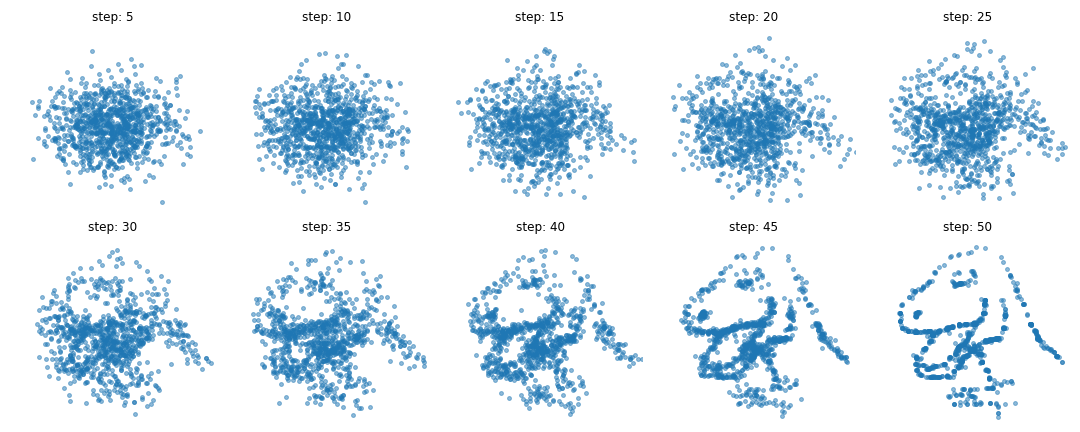

## Еще материалы про диффузионные модели

 * [The Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion)
 * [Diffusion Models From Scratch](https://github.com/tonyduan/diffusion/tree/main)
 * [Diffusers](https://github.com/huggingface/diffusers/)
 * [Классная лекция](https://www.youtube.com/watch?v=YeS3Td5O1kU) от AIRI по введению в диффузионки




# Блиц

## VAE

### Чем `AutoEncoder` отличается от `VariatinalAutoEncoder`? Какая мотивация?

<!-- VAE имеет более сглаженное  -->


### Как можно использовать `AutoEncoder` для задачи поиска аномалий? Какой из вариантов автоенкодера для этого лучше всего подходит?

### Автоенкодеры -- это генеративная модель? Можно ли запустить генерацию чего-либо через автоенкодеры? Как ей управлять?

### Какие метрики качества можно использовать во время обучения автоенкодеров?

## Diffusion

### Зачем в диффузии нужно большое количество шагов?

<!--

* С меньшим кол-вом шагов работает хуже или не работает) Рекомендуется ~ 1к шагов

 -->


### Что такое прямой процесс диффузии? Чем отличается от обратного?

<!-- Во время прямого процесса диффузии мы зашумляем картинку. Используется только во время обучения и не последовательно по шагам, и для любого x_0 мы можем вычислить x_t в идеале за константу.


Во время обратного процесса диффузии мы восстанавливаем сэмпл из шума, используя
обученную модель.
 -->


### Почему для диффузии важно, чтобы $ x_t \sim  q_t(x_T | x_0) $ можно было вычислять эффективно?

<!--

Потому что во время обучения этот метод вызывается большое количество раз.

В теории, можно заранее насэмплировать большой датасет с зашумлением на разных шагах. Но это потребует большого количества диска.

 -->


### Какие недостатки есть у диффузионных моделей? Как с ними можно бороться?

<!--
Долгий сэмплинг -- бороться через дистилляцию, квантизацию или прунинг.
 -->



### Как механизм внимания можно применить в диффузионных моделях?

<!-- В контексте изображений, например, так же как в ViT -- для моделирования взаимодействия между разными патчами изображения -->


### Что такое importance sampling в контексте диффузионок? Какую проблему он решает? Как влияет на обучение?

<!--

Timestep Importance Sampling используются для ускорения обучения.

Обычно на больших значениях `t` обучить модель сложнее, чем на маленьких (когда уже есть большое количество информации в самом семпле)


Поэтому на больших значениях `t` нам нужно больше примеров для обучения.

Importance Sampling управляет частотой сэмплирования таймстепов таким образом, что для таймстепов с большими значениями лосса будут выдаваться большие частоты.

 -->


### Как можно было бы сделать диффузию в дискретном пространстве?

<!--

Аналогично VQ VAE - можно перейти в дискретное скрытое пространство.

В этом случае для прямого процесса диффузии используется матрица переходов.

Но в целом общий подход к диффузии сохраняется таким же как для непрерывной диффузии в контексте скрытого пространства (PS не путать с непрерывной диффузией в контексте таймстепов - гуглится по "Continuous-Time Diffusion").

Если интересна эта тема, можно начать вот с этой работы
https://github.com/microsoft/VQ-Diffusion/tree/main

 -->

### Что является результатом вычисления `.forward()` для диффузионки?

<!--

Обычно предсказывается шум, который надо вычесть из сэмпла.

Но есть разные стратегии:
* можно предсказывать шум
* можно предсказывать предыдущий сэмпл x_{t-1}
* можно предсказывать исходный сэмпл x_0

 -->


### На каких слоях и как используются timestep'ы в диффузионных моделях?

<!--
Тут тоже есть разные подходы:

* можно сконкатенировать обучаемый эмбэддинг с вектором признаков и передать в MLP
* можно закодировать через AdaLayerNorm -- по сути, добавляет смещение для сгенерированного сэмпла https://github.com/huggingface/diffusers/blob/fdb05f54ef61007a8f77ad8537b292176d13fafb/src/diffusers/models/normalization.py#L28

 -->



# Обзор домашек